In [1]:
#!conda update --all --yes
!conda install cudnn --yes
!pip install --upgrade pip
!pip install tensorflow-gpu
!pip install imutils
!pip install tqdm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.3.1)


In [2]:
#!mkdir data
#!curl https://ecs.victoria.ac.nz/foswiki/pub/Courses/COMP309_2019T2/Assignments/Train_data_2019.zip -o data/train.zip
#!unzip -o data/train.zip -d data

In [3]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
import imageio
import random
import math
import shutil

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

make_dir = lambda path: os.path.exists(path) or os.makedirs(path)

In [56]:
epochs = 25
IMG_HEIGHT = 300
IMG_WIDTH = 300
train_pct = 0.8
batch_size = 128

In [5]:
random.seed(309)

make_dir('data/train')
make_dir('data/test')

for label_dir in glob.glob('data/Train_data/*'):    
    label = label_dir.split('/')[-1]
    make_dir(f'data/train/{label}')
    make_dir(f'data/test/{label}')
    
    images = glob.glob(f'{label_dir}/*')
    random.shuffle(images)
    
    split_index = math.floor(len(images) * train_pct)
    for i, image in enumerate(images):
        train_or_test = 'train' if i < split_index else 'test'
        new_path = image.replace('Train_data', train_or_test)
        
        shutil.move(image, new_path)

In [52]:
data_augmentation = dict(
    horizontal_flip=True,
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.1,
    shear_range=10,
    brightness_range=[0.75, 1.25],
)

train_data_gen = ImageDataGenerator(rescale=1.0/255, **data_augmentation).flow_from_directory(
    batch_size=batch_size,
    directory='data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

test_data_gen = ImageDataGenerator(rescale=1.0/255, **data_augmentation).flow_from_directory(
    batch_size=batch_size,
    directory='data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

Found 3600 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


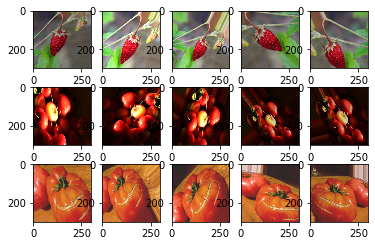

In [53]:
_, axes = plt.subplots(3, 5)

for image in range(axes.shape[0]):
    for example in tqdm(range(axes.shape[1])):
        axes[image,example].imshow(train_data_gen[0][0][image])

In [57]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=epochs,
)

Epoch 1/25
 4/29 [===>..........................] - ETA: 1:27 - loss: 5.6635 - accuracy: 0.3672

In [59]:
12

12

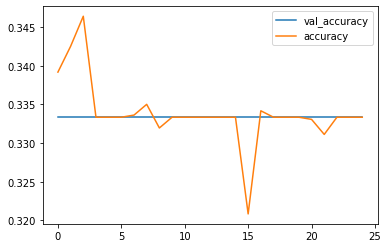

In [64]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()